# PROCESAMIENTO DE LENGUAJE NATURAL

### Iñigo Gómez Carvajal y Jon Zorrilla Gamboa

### Pareja 8

---



### Lab assignments: Aspect opinion extraction

In [207]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


nltk.download('punkt')
nltk.download('wordnet')
nltk.download("omw-1.4")
nltk.download('opinion_lexicon')
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.corpus import opinion_lexicon
from nltk.corpus import wordnet as wn

# Assignment 1: Review datasets

## Task 1.1 

In [3]:
# Open hotel reviews and parse the json
with open('yelp_hotels.json', encoding='utf-8') as f:
  reviews = json.load(f)
f.close()
numReviews = len(reviews)
print(numReviews, 'reviews loaded')
print(reviews[0])
print(reviews[0].get('reviewerID'))

5034 reviews loaded
{'reviewerID': 'qLCpuCWCyPb4G2vN-WZz-Q', 'asin': '8ZwO9VuLDWJOXmtAdc7LXQ', 'summary': 'summary', 'reviewText': "Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!", 'overall': 4.0}
qLCpuCWCyPb4G2vN-WZz-Q


## Task 1.2

In [4]:
# Open beauty spas reviews and parse the json with
# minor tweaks to fit the format
beauty_spas = []
with open('yelp_beauty_spas.json', encoding='utf-8') as f:
  lines = f.readlines()[1:-1]
  for line in lines:
    stripped = line.rstrip().rstrip(",")
    aux = json.loads(stripped)
    beauty_spas.append(aux)
f.close()
numReviews = len(beauty_spas)
print(numReviews, 'beauty_spas loaded')
print(beauty_spas[0])
print(beauty_spas[0].get('reviewerID'))

5579 beauty_spas loaded
{'reviewerID': 'Xm8HXE1JHqscXe5BKf0GFQ', 'asin': 'WGNIYMeXPyoWav1APUq7jA', 'summary': 'summary', 'reviewText': "Good tattoo shop. Clean space, multiple artists to choose from and books of their work are available for you to look though and decide who's style most mirrors what you're looking for. I chose Jet to do a cover-up for me and he worked with me on the design and our ideas and communication flowed very well. He's a very personable guy, is friendly and keeps the conversation going while he's working on you, and he doesn't dick around (read: He starts to work and continues until the job is done). He's very professional and informative. Good customer service combines with talent at the craft.", 'overall': 4.0}
Xm8HXE1JHqscXe5BKf0GFQ


In [5]:
restaurants = []
with open('yelp_restaurants.json', encoding='utf-8') as f:
  lines = f.readlines()[1:-1]
  for line in lines:
    stripped = line.rstrip().rstrip(",")
    aux = json.loads(stripped)
    restaurants.append(aux)
f.close()
numReviews = len(restaurants)
print(numReviews, 'restaurants loaded')
print(restaurants[0])
print(restaurants[0].get('reviewerID'))

158430 restaurants loaded
{'reviewerID': 'rLtl8ZkDX5vH5nAx9C3q5Q', 'asin': '9yKzy9PApeiPPOUJEtnvkg', 'summary': 'summary', 'reviewText': 'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better.Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I\'ve ever had. I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing.While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I\'ve ever had.Anyway, I can\'t

# Assignment 2: Aspect vocabularies.

## Task 2.1

For this section, we will explore the dataset containing relevant aspects for hotels and related terms

In [345]:
f = open("./aspects_hotels.csv", "r")
all_tokens = []
for l in f:
  tokens = l.rstrip('\n').split(",")
  all_tokens.append([tokens[0], tokens[1]])
  print(tokens[0], tokens[1])

amenities amenity
amenities amenities
amenities services
atmosphere atmosphere
atmosphere atmospheres
atmosphere ambiance
atmosphere ambiances
atmosphere light
atmosphere lighting
atmosphere lights
atmosphere music
bar bar
bar bars
bar bartender
bar bartenders
bathrooms bathroom
bathrooms bathrooms
bathrooms bath
bathrooms baths
bathrooms bathtub
bathrooms bathtubs
bathrooms shampoo
bathrooms shampoos
bathrooms shower
bathrooms showers
bathrooms towel
bathrooms towels
bathrooms tub
bathrooms tubs
bedrooms bedroom
bedrooms bedrooms
bedrooms bed
bedrooms beds
bedrooms pillow
bedrooms pillows
bedrooms sheet
bedrooms sheets
bedrooms sleep
bedrooms suite
bedrooms suites
booking booking
booking book
booking reservation
booking reservations
booking reserve
breakfast breakfast
breakfast breakfasts
breakfast morning
breakfast mornings
breakfast toast
breakfast toasts
breakfast moorning meal
breakfast moorning menu
building building
building buildings
building architecture
building architectures

As we can see, the first part of the token refers to the aspect, while the second is the aspect term that relates to the aspect. We will generate a dictionary containing the aspect as a key and an array of its terms as the value

In [346]:
tokens_dict = {}
for tokens in all_tokens:
  if tokens[0] not in tokens_dict.keys():
    tokens_dict[tokens[0]] = [tokens[1]]
  else:
    tokens_dict[tokens[0]].append(tokens[1])

In [347]:
print(tokens_dict)

{'amenities': ['amenity', 'amenities', 'services'], 'atmosphere': ['atmosphere', 'atmospheres', 'ambiance', 'ambiances', 'light', 'lighting', 'lights', 'music'], 'bar': ['bar', 'bars', 'bartender', 'bartenders'], 'bathrooms': ['bathroom', 'bathrooms', 'bath', 'baths', 'bathtub', 'bathtubs', 'shampoo', 'shampoos', 'shower', 'showers', 'towel', 'towels', 'tub', 'tubs'], 'bedrooms': ['bedroom', 'bedrooms', 'bed', 'beds', 'pillow', 'pillows', 'sheet', 'sheets', 'sleep', 'suite', 'suites'], 'booking': ['booking', 'book', 'reservation', 'reservations', 'reserve'], 'breakfast': ['breakfast', 'breakfasts', 'morning', 'mornings', 'toast', 'toasts', 'moorning meal', 'moorning menu'], 'building': ['building', 'buildings', 'architecture', 'architectures', 'buildings', 'decor', 'decoration', 'decorations', 'furniture', 'furnitures', 'garden', 'gardens', 'hall', 'halls', 'lobbies', 'lobby', 'lounge', 'lounges', 'patio', 'patios', 'salon', 'salons', 'spot', 'spots'], 'checking': ['checkin', 'check-in

## Task 2.2

In this task we will add more terms to each aspect by using WordNet's synset, giving us more coverage when trying to retrieve aspects from the reviews. In addition, for the sake of usability and ease of coding in later tasks, we'll invert the structure of the dictionary, meaning the array of values for each key will become a set of keys, with the aspect as the value for these keys.

In [348]:
#For each aspect in the dictionary, find synonyms.
for word in tokens_dict.keys():
  synsets = wn.synsets(word)
  synonyms = []
  for s in synsets:
    for l in s.lemmas():
      synonyms.append(l.name())
  for syn in synonyms:
    # If the term was not present, append it to the values
    if syn not in tokens_dict[word]:
      tokens_dict[word].append(syn)

# Dictionary inversion
tokens_dict_inv = {}

for key in tokens_dict.keys():
  for value in tokens_dict[key]:
    tokens_dict_inv[value] = key

tokens_dict = tokens_dict_inv

In [349]:
print(list(tokens_dict.items())[5:10])

[('conveniences', 'amenities'), ('agreeableness', 'amenities'), ('atmosphere', 'atmosphere'), ('atmospheres', 'atmosphere'), ('ambiance', 'atmosphere')]


# Assignment 3: Opinion lexicons
## Task 3.1

Given Liu's opinion lexicon, we will load the words in a dictionary, in which positive words will have a value of 1, and negative words a value of -1

In [333]:
negativeWords = opinion_lexicon.negative()
positiveWords = opinion_lexicon.positive()

negative = np.array((word, -1) for word in negativeWords)
positive = np.array((word, 1) for word in positiveWords)

polarities = {}

for word in negativeWords:
    polarities[word] = -1

for word in positiveWords:
    polarities[word] = 1

list(polarities.items())[0:5]

[('2-faced', -1),
 ('2-faces', -1),
 ('abnormal', -1),
 ('abolish', -1),
 ('abominable', -1)]

# Task 3.2 & 3.3

We defined a function called load_modifiers, which generates a dictionary with the modifier words as keys and the modifier as a value for task 3.2

As for part 3.3, we decided that a simple case of polarity inversion in sentences occurs when there's presence of the adverb 'not' in it. So, to model this particular case, we decided to add to the modifiers dictionary the term 'not' with value -1. This will provide us with some (although limited) capacity of finding polarity inversions when we perform the aspect extraction.

In [350]:
# Generation of modifiers dictionary

def load_modifiers(path='modifiers.csv'):
    file = pd.read_csv(path, sep=',', header=None, names=['modifier', 'multiplier'])
    modifiers = {row[0]: row[1] for _, row in file.iterrows()}
    # TASK 3.3 Addition of the 'not' term as a negative modifier
    modifiers['not'] = -1
    return modifiers

In [351]:
modifiers = load_modifiers()
list(modifiers.items())[0:5]

[('above', 2.0),
 ('absolutely', 2.0),
 ('abundantly', 2.0),
 ('acutely', 2.0),
 ('amazingly', 2.0)]

# Assignment 4: Aspect opinions
## Task 4.1, 4.2 & 4.3

The logic behind this function is explained in full detail in the attached pdf. Within it, we take into account all the tasks for the assignment at the same time.

For the POS tagging we use NLTK's *sent_tokenize()* function. As for the dependency parsing, we decided to use the CoreNLP's *raw_parse()*.

In [352]:
dependency_parser = CoreNLPDependencyParser(url='http://localhost:9000')
sentences = nltk.sent_tokenize(reviews[0].get("reviewText"))

for s in sentences:
    print(s)
    result, = dependency_parser.raw_parse(s)
    for head, relation, dependent in result.triples():
        print(head, relation, dependent)

Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car.
('hotel', 'NN') amod ('Great', 'JJ')
('hotel', 'NN') nmod ('Phoenix', 'NNP')
('Phoenix', 'NNP') case ('in', 'IN')
('Phoenix', 'NNP') compound ('Central', 'NNP')
('hotel', 'NN') nmod ('cation', 'NN')
('cation', 'NN') case ('for', 'IN')
('cation', 'NN') det ('a', 'DT')
('cation', 'NN') compound ('stay', 'NN')
('cation', 'NN') punct ('-', 'HYPH')
('hotel', 'NN') punct (',', ',')
('hotel', 'NN') conj ('place', 'NN')
('place', 'NN') cc ('but', 'CC')
('place', 'NN') advmod ('not', 'RB')
('place', 'NN') advmod ('necessarily', 'RB')
('place', 'NN') det ('a', 'DT')
('place', 'NN') dep ('stay', 'VB')
('stay', 'VB') mark ('to', 'TO')
('stay', 'VB') obl ('town', 'NN')
('town', 'NN') case ('out', 'IN')
('town', 'NN') case ('of', 'IN')
('stay', 'VB') conj ('car', 'NN')
('car', 'NN') cc ('and', 'CC')
('car', 'NN') case ('without', 'IN')
('car', 'NN') det ('a', 'DT')
('hotel', 'NN') pun

In [353]:
def review_aspect_extraction(review, opinion, modifiers, aspect_vocab):

    dependency_parser = CoreNLPDependencyParser(url='http://localhost:9000')
    results = []
    sentences = nltk.sent_tokenize(review)
    
    for s in sentences:
        # Retrieve dependencies and POS from CoreNLP's raw_parse function
        result, = dependency_parser.raw_parse(s)
        aspect_tuples = []
        modifiers_list = []
        compound_list = []
        conj_list = []
        for head, relation, dependent in result.triples():
            
            if head[1].startswith('NN'):

                # Find adjectival modifiers (amod) of nouns to add as a potential aspect tuple
                if relation == "amod":
                    score = opinion.get(dependent[0].lower(), 0)
                    aspect_tuples.append((head[0], dependent[0], score))

                # Find compound nouns to search for possible aspect terms within them
                if relation == "compound":
                    compound_list.append((head[0], dependent[0]))
            
            # Find adverbial modifiers (advmod) on the sentence and store the reference, the adverb and the modifier value
            elif (head[1].startswith('JJ') or head[1].startswith('NN')) and relation == "advmod":
                mod = modifiers.get(dependent[0].lower(), 1)
                modifiers_list.append((head[0], dependent[0], mod))

            # Look for adjectives in succession that refer to the same word and store to create a new tuple later
            elif (head[1].startswith('JJ') and dependent[1].startswith('JJ') and relation == "conj"):
                conj_list.append((head[0], dependent[0]))

            # Look for nominal subjects with adjectives to add as a potential aspect tuple
            elif (head[1].startswith('JJ') and dependent[1].startswith('NN') and relation == "nsubj"):
                score = opinion.get(head[0].lower(), 0)
                aspect_tuples.append((dependent[0], head[0], score))

        # Create aspect tuples for nouns that were part of a compound noun but have
        # no direct relation with an adjective
        for compound in compound_list:
            for aspect_tuple in aspect_tuples:
                if compound[0] == aspect_tuple[0]:
                    aspect_tuples.append((compound[1], aspect_tuple[1], aspect_tuple[2]))

        
        # Create aspect tuples for adjectives that were in conjunct with other
        # adjectives
        for conj in conj_list:
            for aspect_tuple in aspect_tuples:
                if conj[0] == aspect_tuple[1]:
                    score = opinion.get(conj[1].lower(), 0)
                    aspect_tuples.append((aspect_tuple[0], conj[1], score))

        for aspect_tuple in aspect_tuples:
            # If the aspect term is on the aspect terms dictionary, process the polarity
            if aspect_tuple[0].lower() in aspect_vocab.keys():
                isNegated = "Non negated"
                tuple_list = list(aspect_tuple)
                aux_modifiers = []

                # Process the modifiers for the tuple
                for modifier in modifiers_list:
                    if modifier[0] in (tuple_list[0], tuple_list[1]):
                        tuple_list[2] *= modifier[2]
                        aux_modifiers.append(modifier[1])
                        # If 'not' is found, we mark the inversion in polarity
                        if modifier[1].lower() == 'not':
                            isNegated="Negated"
            
                tuple_list.append(aspect_vocab[tuple_list[0].lower()])
                
                # Store the [aspect, aspect term, opinion word, isNegated, modfiers, polarity] tuple
                results.append((aspect_vocab[tuple_list[0].lower()], 
                                tuple_list[0],
                                tuple_list[1],
                                isNegated,
                                aux_modifiers,
                                tuple_list[2]))

    return results

### Test applying different modifiers and negations

In [354]:
# Applying modifiers on different sentences
review_aspect_extraction("Great bar. Incredibly bad bedrooms", polarities, modifiers, tokens_dict)

[('bar', 'bar', 'Great', 'Non negated', [], 1),
 ('bedrooms', 'bedrooms', 'bad', 'Non negated', ['Incredibly'], -2.0)]

In [355]:
# Applying modifiers of different value and conjunct adjectives
review_aspect_extraction("Slightly dirty and incredibly bad bedrooms", polarities, modifiers, tokens_dict)

[('bedrooms', 'bedrooms', 'dirty', 'Non negated', ['Slightly'], -0.5),
 ('bedrooms', 'bedrooms', 'bad', 'Non negated', ['incredibly'], -2.0)]

In [356]:
# Applying polarity inversion
review_aspect_extraction("The food was not bad at all", polarities, modifiers, tokens_dict)

[('cuisine', 'food', 'bad', 'Negated', ['not'], 1)]

In [357]:
results = review_aspect_extraction(reviews[40].get("reviewText"), polarities, modifiers, tokens_dict)

In [358]:
# DataFrame structure for next assignment
aspects_df = pd.DataFrame(results, columns=['aspect', 'term', 'opinion', 'isNegated', 'modifiers', 'polarity'])
aspects_df.head()

,aspect,term,opinion,isNegated,modifiers,polarity
0,bedrooms,pillows,amazing,Non negated,[absolutely],2.0
1,bedrooms,pillows,best,Non negated,[],1.0
2,restrooms,convenience,amazing,Non negated,[],1.0
3,restaurant,restaurants,local,Non negated,[],0.0


# Assignment 5
## Task 5.1

For this task, we decided to process the aspect tuples as a DataFrame, which will make aggregation easier.

In [359]:
def group_aspects(aspect_opinion):
    # Returns the aspects mentioned with the sum of polarity of the DataFrame
    aspect_opinion_sum = aspect_opinion[['aspect', 'polarity']].groupby('aspect').sum().reset_index()
    return aspect_opinion_sum

In [360]:
def plot_aspect_opinion(aspect_opinion):

    # Transform the array of tuples as a DataFrame and aggregate all polarities grouped by aspect
    aspect_df = pd.DataFrame(aspect_opinion, columns=['aspect', 'term', 'opinion', 'isNegated', 'modifiers', 'polarity'])
    aspect_opinion_sum = group_aspects(aspect_df)

    #Plot the values
    plt.bar(x=aspect_opinion_sum['aspect'],
        height=aspect_opinion_sum['polarity'],
        color = plt.cm.rainbow(np.linspace(0, 1, len(aspect_opinion_sum))))

This is my favorite spa in the world! Hopefully, I'll make it to others...but if I could only get to the Camelback Inn, I'd be in heaven. Here's the rundown of how I enjoy the place: Early morning appointment for massage - Rose does fantastic hot stone - I like her the best. Then I shower and get into the eucalyptus steam room. Next I head out to the pool and savor the view of Camelback Mountain and the amazing desert landscaping they've procured. I drink some water and as I lounge there, I order a small, healthy and very tasty meal (usually breakfast). I swim a little, lounge a lot - regardless of the time of year. If I have planned it, I then head back into the showers and clean up for my next treatment. I spend hours there and if I feel like I might be pressed for time, I reschedule.


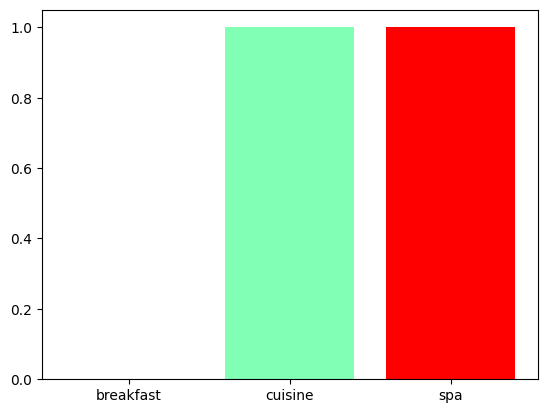

In [361]:
aspect_opinion = review_aspect_extraction(reviews[3].get("reviewText"), polarities, modifiers, tokens_dict)
print(reviews[3].get("reviewText"))
plot_aspect_opinion(aspect_opinion)

# TASK 5.2

The idea behind the first part of this task is the same as in 5.1, with the only difference being the DataFrame is being made with all the tuples from all the reviews of the hotel.

As for the positive/negative opinions, we process polarities as negative or positive, aggregate them by aspect, and plot both values on the screen

In [362]:
def plot_hotel_reviews(hotel_reviews):

    aspect_opinions = []

    fig, ax = plt.subplots(1, 1, figsize = (20,10))

    # Generate aspect tuples for all the reviews and perform an aggregation, similar to 5.1
    for review in hotel_reviews:
        aspect_opinions.extend(review_aspect_extraction(review["reviewText"], polarities, modifiers, tokens_dict))

    print(f"Results from {len(hotel_reviews)} reviews")

    # Call plot_aspect_opinion to plot the final results
    plot_aspect_opinion(aspect_opinions)
    plt.title("Aspect rating for hotel given according to user reviews")

    for tick in ax.get_xticklabels():
        tick.set_rotation(70)


### Test with the reviews referring to the hotel mentioned in 3rd review

Results from 102 reviews


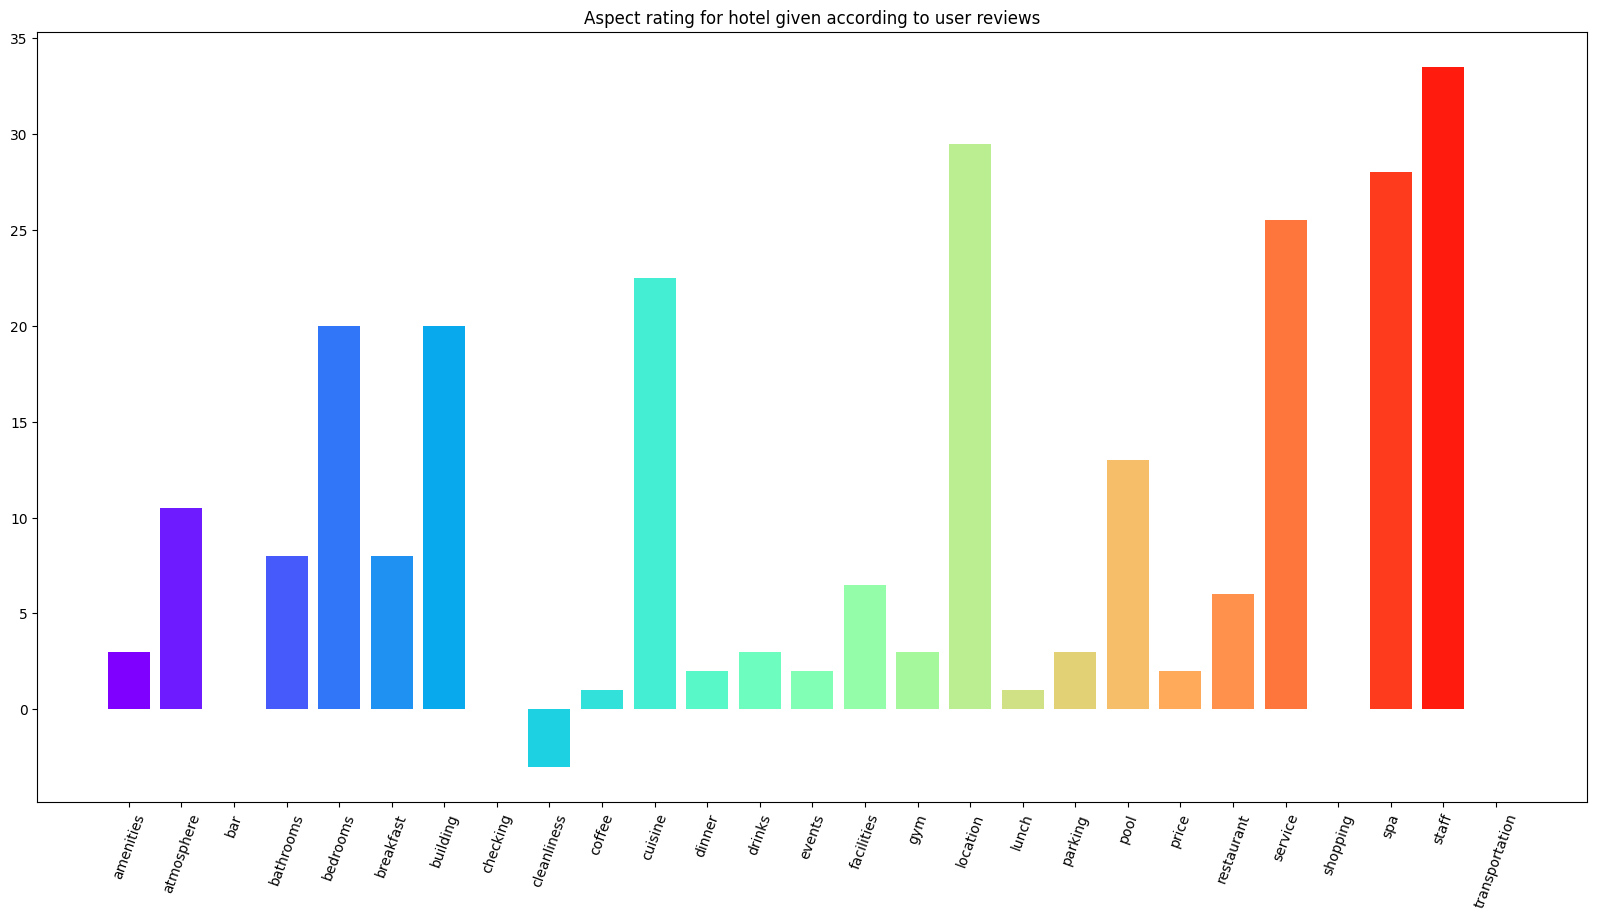

In [363]:
hotel_asin = reviews[2]['asin']
hotel_reviews = [ x for x in reviews if x['asin'] == hotel_asin ]

plot_hotel_reviews(hotel_reviews)

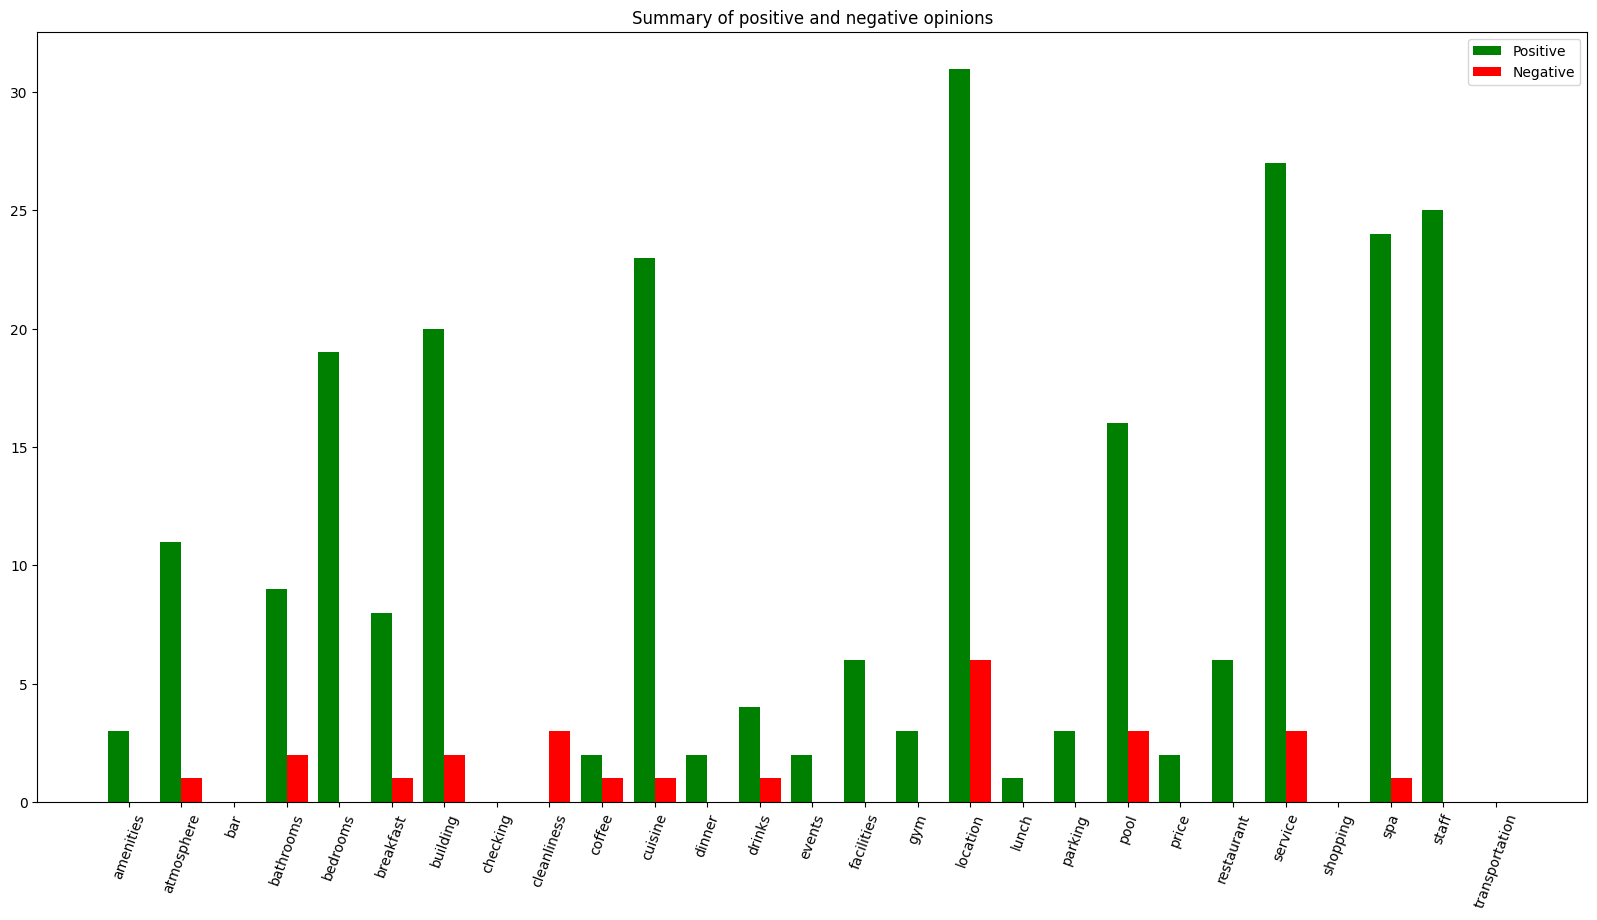

In [364]:
def positive_negative_counter(hotel_reviews):

    aspect_opinions = []

    # Generate aspect tuples for all the reviews and perform an aggregation, similar to 5.1
    for review in hotel_reviews:
        aspect_opinions.extend(review_aspect_extraction(review["reviewText"], polarities, modifiers, tokens_dict))

    aspect_df = pd.DataFrame(aspect_opinions, columns=['aspect', 'term', 'opinion', 'isNegated', 'modifiers', 'polarity'])

    # Generate 2 new columns, positiveOpinion, which will have a value of 1 if polarity is greater than 0
    # and negativeOpinion, which will have a value of 1 if polarity is less than 0
    aspect_df['positiveOpinion'] = np.where(aspect_df['polarity'] > 0, 1, 0)
    aspect_df['negativeOpinion'] = np.where(aspect_df['polarity'] < 0, 1, 0)

    aspect_df = aspect_df[['aspect', 'positiveOpinion', 'negativeOpinion']].groupby('aspect').sum().reset_index()

    return aspect_df

def plot_positive_negative_opinion(hotel_reviews):

    fig, ax = plt.subplots(1, 1, figsize = (20,10))
    
    df = positive_negative_counter(hotel_reviews)
    
    X_axis = np.arange(len(df))

    plt.bar(X_axis - 0.2, df['positiveOpinion'], 0.4, label = 'Positive', color="green")
    plt.bar(X_axis + 0.2, df['negativeOpinion'], 0.4, label = 'Negative', color="red")
    plt.xticks(X_axis, df['aspect'])
    plt.legend()
    plt.title("Summary of positive and negative opinions")

    for tick in ax.get_xticklabels():
        tick.set_rotation(70)

plot_positive_negative_opinion(hotel_reviews)